In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

In [2]:
class TwoConvBlock_2D(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding="same")
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.rl = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding="same")
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.rl(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.rl(x)
    return x

class Discriminator(nn.Module):   #識別器
  def __init__(self):
    super().__init__()
    self.conv1 = TwoConvBlock_2D(1,64)
    self.conv2 = TwoConvBlock_2D(64, 128)
    self.conv3 = TwoConvBlock_2D(128, 256)

    self.avgpool_2D = nn.AvgPool2d(2, stride = 2)
    self.global_avgpool_2D = nn.AvgPool2d(7)

    self.l1 = nn.Linear(256, 20)
    self.l2 = nn.Linear(20, 1)
    self.rl = nn.LeakyReLU()
    self.dropout1 = nn.Dropout(0.5)
    self.dropout2 = nn.Dropout(0.1)
    self.embed = nn.Embedding(10, 256)

  def forward(self, x, y):
    x = self.conv1(x)
    x = self.avgpool_2D(x)
    x = self.conv2(x)
    x = self.avgpool_2D(x)
    x = self.conv3(x)
    x = self.global_avgpool_2D(x)
    x = x.view(-1, 256)
    _x = x
    x = self.dropout1(x)
    x = self.l1(x)
    x = self.rl(x)
    x = self.dropout2(x)
    x = self.l2(x)

    _y = self.embed(y)   #ラベルをembedding層で埋め込む
    xy = (_x*_y).sum(1, keepdim=True)   #出力ベクトルとの内積をとる

    x = x+xy   #内積を加算する
    x = torch.sigmoid(x)
    return x

class Generator(nn.Module):   #生成器
  def __init__(self):
    super().__init__()
    self.l = nn.Linear(110, 49)
    self.dropout = nn.Dropout(0.2)
    self.TCB1 = TwoConvBlock_2D(1,512)
    self.TCB2 = TwoConvBlock_2D(512,256)
    self.TCB3 = TwoConvBlock_2D(256,128)
    self.UC1 = nn.ConvTranspose2d(512, 512, kernel_size =2, stride = 2)
    self.UC2 = nn.ConvTranspose2d(256, 256, kernel_size =2, stride = 2)
    self.conv1 = nn.Conv2d(128, 1, kernel_size = 2, padding="same")
  

  def forward(self, x, y):
    y = torch.nn.functional.one_hot(y.long(), num_classes=10).to(torch.float32)
    x = torch.cat([x, y], dim= 1)
    x = self.dropout(x)
    x = self.l(x)
    x = torch.reshape(x, (-1, 1, 7, 7))
    x = self.TCB1(x)
    x = self.UC1(x)
    x = self.TCB2(x)
    x = self.UC2(x)
    x = self.TCB3(x)
    x = self.conv1(x)
    x = torch.sigmoid(x)
    return x


In [3]:
BATCH_SIZE = 16

train_data = MNIST("../mnist", 
                   train=True, 
                   download=False, 
                   transform=transforms.ToTensor())

train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
print("train data size: ",len(train_data))   #train data size:  60000
print("train iteration number: ",len(train_data)//BATCH_SIZE)   #train iteration number:  3750


train data size:  60000
train iteration number:  3750


images_size: torch.Size([16, 1, 28, 28])
label: tensor([5, 2, 5, 6, 3, 1, 9, 4, 5, 5, 5, 5, 0, 7, 4, 7])


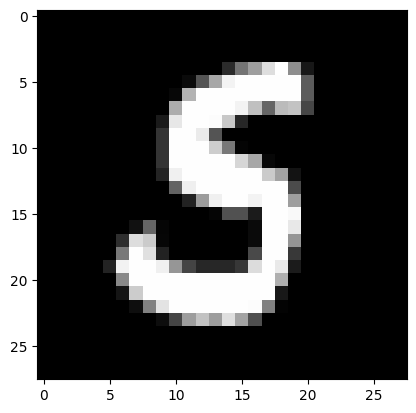

In [4]:
images, labels = next(iter(train_loader))
print("images_size:",images.size())   #images_size: torch.Size([16, 1, 28, 28])
print("label:",labels)   #label: tensor([7, 3, 0, 3, 7, 2, 5, 3, 2, 0, 8, 7, 4, 9, 5, 7])

image_numpy = images.detach().numpy().copy()
plt.imshow(image_numpy[0,0,:,:], cmap='gray')

In [6]:
device = torch.device('mps')
model_D = Discriminator().to(device)
model_G = Generator().to(device)

true_labels = torch.ones(BATCH_SIZE).reshape(BATCH_SIZE, 1).to(device)   #1のラベル
fake_labels = torch.zeros(BATCH_SIZE).reshape(BATCH_SIZE, 1).to(device)   #0のラベル

criterion = nn.BCELoss()    #損失関数はBCE(Binary Cross Entropy)を使用

optimizer_D = optim.Adam(model_D.parameters(), lr=0.00001)   #最適化関数はAdamを使用
optimizer_G = optim.Adam(model_G.parameters(), lr=0.00001)

epoch_num = 5   #エポック数（同じデータセットを何回学習するか）
print_coef = 10
G_train_ratio = 2   #識別器の学習1回あたり生成器が学習する回数
train_length = len(train_data)

def calc_acc(pred):   #正解率の評価関数
  pred = torch.where(pred > 0.5, 1., 0.)
  acc = pred.sum()/pred.size()[0]
  return acc

history = {"loss_D": [], "loss_G": [], "acc_true": [], "acc_fake": []}
n = 0
m = 0

for epoch in range(epoch_num):
  train_loss_D = 0
  train_loss_G = 0
  train_acc_true = 0
  train_acc_fake = 0

  model_D.train()
  model_G.train()
  for i, data in enumerate(train_loader):
    optimizer_D.zero_grad()
    inputs, labels = data[0].to(device), data[1].to(device)

    #識別器の学習（1）
    outputs = model_D(inputs, labels)   #本物の画像が本物か偽物か判定
    loss_true = criterion(outputs, true_labels)   #本物のデータを本物と判定するように学習したいので1のラベルを使用
    acc_true = calc_acc(outputs)

    #識別器の学習（2）
    noise = torch.randn((BATCH_SIZE, 100), dtype=torch.float32).to(device)   #ランダムな配列を生成
    noise_label = torch.from_numpy(np.random.randint(0,10,BATCH_SIZE)).clone().to(device)   #1~9のランダムな整数を生成
    inputs_fake = model_G(noise, noise_label).to(device)   #偽物の画像を生成
    outputs_fake = model_D(inputs_fake.detach(), noise_label)   #偽物の画像が本物か偽物か判定
    loss_fake = criterion(outputs_fake, fake_labels)   #偽物の画像を偽物と判定する方向に学習したいので0のラベルを使用
    acc_fake = calc_acc(outputs_fake)
    loss_D = loss_true + loss_fake   #識別器の学習（1）・（2）の損失を足し合わせる
    loss_D.backward()
    optimizer_D.step()   #識別器のパラメータを更新する

    #生成器の学習
    for _ in range(G_train_ratio):   #G_train_ratioの回数分生成器の学習を繰り返す
      optimizer_G.zero_grad()
      noise = torch.randn((BATCH_SIZE, 100), dtype=torch.float32).to(device)  #ランダムな配列を生成
      noise_label = torch.from_numpy(np.random.randint(0,10,BATCH_SIZE)).clone().to(device)   #1~9のランダムな整数を生成
      inputs_fake = model_G(noise, noise_label).to(device)
      outputs_fake = model_D(inputs_fake, noise_label)
      loss_G = criterion(outputs_fake, true_labels)   #本物と判定される偽物の画像を生成したいので1のラベルを使用
      loss_G.backward()
      optimizer_G.step()   #生成器のパラメータを更新する

    #学習経過の保存
    train_loss_D += loss_D.item()
    train_loss_G += loss_G.item()
    train_acc_true += acc_true.item()
    train_acc_fake += acc_fake.item()
    n += 1
    history["loss_D"].append(loss_D.item())
    history["loss_G"].append(loss_G.item())
    history["acc_true"].append(acc_true.item())
    history["acc_fake"].append(acc_fake.item())

    if i % ((train_length//BATCH_SIZE)//print_coef) == (train_length//BATCH_SIZE)//print_coef - 1:
      print(f"epoch:{epoch+1}  index:{i+1}  loss_D:{train_loss_D/n:.10f}  loss_G:{train_loss_G/n:.10f}  acc_true:{train_acc_true/n:.10f}  acc_fake:{train_acc_fake/n:.10f}")

      n = 0
      train_loss_D = 0
      train_loss_G = 0
      train_acc_true = 0
      train_acc_fake = 0

print("finish training")


epoch:1  index:375  loss_D:2.3708316004  loss_G:4.5058619499  acc_true:0.7328333333  acc_fake:0.1795000000
epoch:1  index:750  loss_D:0.3410997375  loss_G:4.3490830447  acc_true:0.9531666667  acc_fake:0.0610000000
epoch:1  index:1125  loss_D:0.3860078308  loss_G:4.6790508410  acc_true:0.9646666667  acc_fake:0.1070000000
epoch:1  index:1500  loss_D:0.2990794623  loss_G:4.7521717386  acc_true:0.9673333333  acc_fake:0.0743333333
epoch:1  index:1875  loss_D:0.2114723475  loss_G:5.0712057832  acc_true:0.9748333333  acc_fake:0.0343333333
epoch:1  index:2250  loss_D:0.1727376838  loss_G:5.1233596592  acc_true:0.9773333333  acc_fake:0.0166666667
epoch:1  index:2625  loss_D:0.1673890553  loss_G:5.2029722137  acc_true:0.9760000000  acc_fake:0.0128333333
epoch:1  index:3000  loss_D:0.1522865413  loss_G:5.3024683317  acc_true:0.9756666667  acc_fake:0.0155000000
epoch:1  index:3375  loss_D:0.1486343298  loss_G:5.4952886136  acc_true:0.9776666667  acc_fake:0.0123333333
epoch:1  index:3750  loss_D:0.

<Figure size 640x480 with 0 Axes>

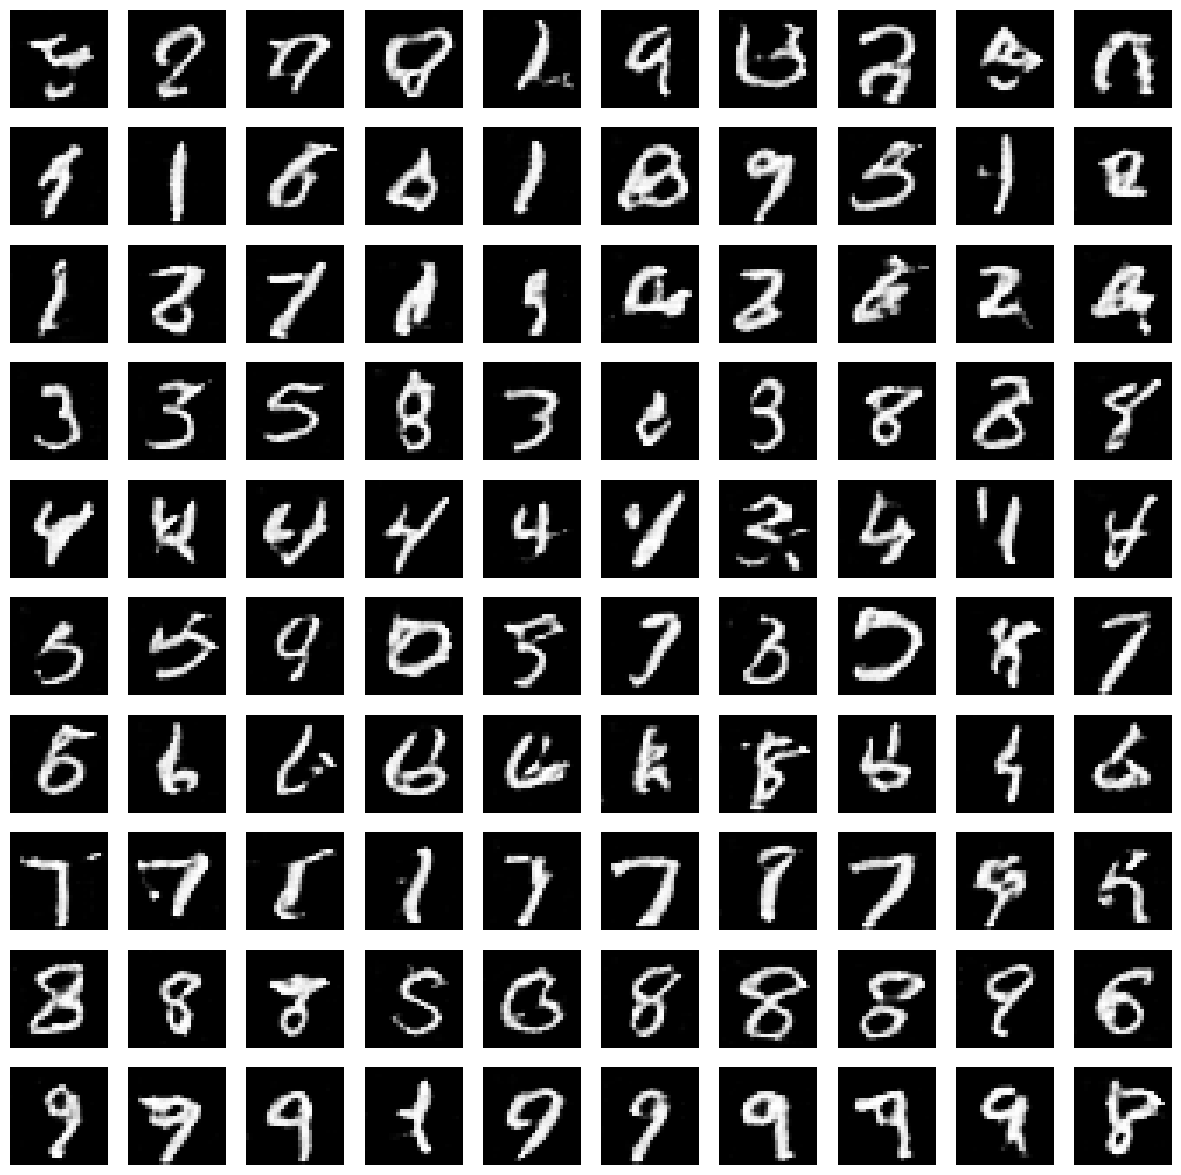

In [8]:
for i in range(10):
  intnp = np.random.randint(i ,i + 1 ,10)
  if i == 0:
    label_np = intnp
  else:
    label_np = np.concatenate([label_np, intnp], 0)

model_G.to("cpu")
with torch.no_grad():
  noise = torch.randn((100, 100), dtype=torch.float32)
  noise_label = torch.from_numpy(label_np).clone()
  syn_image = model_G(noise, noise_label)
  
  plt.figure()
  fig, ax = plt.subplots(10, 10, figsize=(15,15))
  for i in range(10):
    for j in range(10):
        ax[i,j].imshow(syn_image[i * 10 + j,0,:,:], cmap='gray')
        ax[i,j].axis("off")